In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import _pickle as pkl
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics,preprocessing
from sklearn.metrics import confusion_matrix  
from sklearn.svm import SVC

### Preprocessing the dataset

We need to normalize the data before trying to fit any models to this dataset. We only fit the normalizer on the training dataset and use the learned parameters on the validation and test sets.  We use the sklearn's preprocessing library to use the MinMax Normalizer on all the features

In [2]:
def get_dataset(data_file , mode='train', scaler=None, balance_dataset=False):
    """
    Parameters:
        data_file : Path to .csv file that contains the data
        mode : Defines if the dataset to load is train,val or test data - can take values 'train','val' or ,'test' 
        scaler : The scaler to use to normalize data, must be specified for 'val' and 'test' modes. A new scaler 
                 Object is returned when mode=='train' that is fit on the training data
        balance_dataset : Boolean to specify if any imbalance in dataset should be handled.
    """
    
    if mode not in ['train','val','test']:
        raise Exception("mode has to be one of 'train', 'val' or 'test'.Please correct the mode and retry ")
    if mode!='train' and balance_dataset:
        raise exception("Can only balance training dataset Not the validation and Test set")
        
    # read data file into pandas dataframe
    data = pd.read_csv(data_file)
    # Last column is the labels column
#     if mode== 'train' or mode =='val':
    features = data.values[:,:-1]
    labels = data.iloc[:,-1]
#     else:
#         features = data.values
    
    # If mode==train, fit the scaler and tranform the data,
    # else , use a previously fit scaler to only tranform data
    if mode == 'train':
        if not scaler:
            scaler = preprocessing.MinMaxScaler()
        features = scaler.fit_transform(features)
    else:
        features = scaler.transform(features)
    
    # balance data
    if mode == 'train' and balance_dataset:
        positive_labels = labels[labels == 1]
        negative_labels = labels[labels == 0]

        positive_examples = features[positive_labels]
        negative_examples = features[negative_labels]

        # subsample from negative_examples
        idxs = [i for i in range(len(negative_examples))]
        np.random.shuffle(idxs)
        idxs = idxs[:len(positive_examples)]

        # Combine the data
        negative_examples = negative_examples[idxs]
        labels = np.concatenate(([1]*len(positive_examples), [0]*len(positive_examples)))
        features = np.vstack((positive_examples,negative_examples))

        # Shuffle the data
        idxs = [i for i in range(len(features))]
        np.random.shuffle(idxs)
        features = features[idxs]
        labels = labels[idxs]

    if mode =='train':
        return features , labels, scaler
    else:
        return features , labels
#     else:
#         return features
    
# Get train features, labels and fit scaler object
train_features, train_labels, scaler = get_dataset("training_data.csv",mode='train',balance_dataset=False)
# Get validation data, make sure to pass the scaler object obtained from train dataset
val_features, val_labels = get_dataset("validation_data.csv",mode='val',scaler=scaler)
test_features, test_labels = get_dataset("test_data.csv",mode = 'test',scaler = scaler)

### Combining Train and Validation datasets
We combine the train and validation sets once we tune the hyperparamters on the validation set and retrain the entire model. This would help the model to learn better using the validation set while preventing overfitting

**Do this only after initially training the model, i.e by executing the model cells below and then come back to this cell, to combine the data and then run the model cells again on the new set.**

In [11]:
combine = True
# Combine train and val data - do this after hyper parameter tuning on val set
if combine == True:
    features = np.vstack((train_features,val_features))
    labels = np.concatenate((train_labels, val_labels))
    
    # Shuffle the data
    idxs = [i for i in range(len(features))]
    np.random.shuffle(idxs)
    train_features = features[idxs]
    train_labels = labels[idxs]
    

### Working with the Decision threshold and AUROC. 

Generally the decision threshold for classifying an input to belong to the positive class is if and only if the predicted class probability is >=0.5.

In this section, we try to tweak the decision threshold in order to obtain the best performance. After experimenting, the decision threshold of 0.4-0.45 seems to work best by avoiding FALSE NEGATIVES. 

In [3]:
def get_predictions(model, data, decision_threshold):
    pred_probs = model.predict_proba(data)
    preds = (pred_probs[:,1] > decision_threshold).astype(int)
    
    return preds

In [ ]:
decision_threshold = 0.35
# Define model
model = RandomForestClassifier(n_estimators=50, max_depth=4, random_state=0)
# Fit model
model.fit(train_features,train_labels)
# Check score

val_preds = get_predictions(model, val_features, decision_threshold)
train_preds = get_predictions(model,train_features, decision_threshold)
test_preds = get_predictions(model, test_features, decision_threshold)
print("Training set accuracy: ", np.sum((train_preds==train_labels))/len(train_preds))

tn, fp, fn, tp = confusion_matrix(val_labels,val_preds).ravel()
tn_t, fp_t, fn_t, tp_t = confusion_matrix(test_labels,test_preds).ravel()
conMat_RFC = confusion_matrix(val_labels,val_preds)
conMat_RFC_test = confusion_matrix(test_labels, test_preds)

print("Validation set accuracy :", ((tp+tn) / (tp+tn+fp+fn) ))
print("Validation set confusion matrix:")
print(conMat_RFC)
print("Test set accuracy :", ((tp_t+tn_t) / (tp_t+tn_t+fp_t+fn_t) ) )
print(conMat_RFC_test)


In [ ]:
decision_threshold = 0.35
model = MLPClassifier(hidden_layer_sizes=(32,64,128),
                     activation='relu',
                     solver='adam',
                     alpha=1e-2,
                     batch_size=8,
                     learning_rate_init=1e-4,
                     verbose=False,
                     max_iter=500,
                     random_state=0)
model.fit(train_features,train_labels)

val_preds = get_predictions(model, val_features, decision_threshold)
train_preds = get_predictions(model,train_features, decision_threshold)
test_preds = get_predictions(model, test_features, decision_threshold)
print("train accuracy: ", np.sum((train_preds==train_labels))/len(train_preds))

tn, fp, fn, tp = confusion_matrix(val_labels,val_preds).ravel()
tn_t, fp_t, fn_t, tp_t = confusion_matrix(test_labels,test_preds).ravel()
conMat_MLP = confusion_matrix(val_labels,val_preds)
conMat_MLP_test = confusion_matrix(test_labels, test_preds)

print(" Val accuracy :", ((tp+tn) / (tp+tn+fp+fn) ))
print(confusion_matrix(val_labels,val_preds))
print("Test set accuracy :", ((tp_t+tn_t) / (tp_t+tn_t+fp_t+fn_t) ) )
print(conMat_MLP_test)

In [16]:
decision_threshold = 0.40
model = GradientBoostingClassifier(n_estimators=40, max_depth=4,random_state=0)
model.fit(train_features,train_labels)

val_preds = get_predictions(model, val_features, decision_threshold)
train_preds = get_predictions(model,train_features, decision_threshold)
test_preds = get_predictions(model, test_features, decision_threshold)
print("train accuracy: ", np.sum((train_preds==train_labels))/len(train_preds))

tn, fp, fn, tp = confusion_matrix(val_labels,val_preds).ravel()
tn_t, fp_t, fn_t, tp_t = confusion_matrix(test_labels,test_preds).ravel()
conMat_GBC = confusion_matrix(val_labels,val_preds)
conMat_GBC_test = confusion_matrix(test_labels, test_preds)

print(" Val accuracy :", ((tp+tn) / (tp+tn+fp+fn) ))
print(confusion_matrix(val_labels,val_preds))
print("Test set accuracy :", ((tp_t+tn_t) / (tp_t+tn_t+fp_t+fn_t) ) )
print(conMat_GBC_test)

train accuracy:  1.0
 Val accuracy : 1.0
[[66  0]
 [ 0 21]]
Test set accuracy : 0.5572139303482587
[[96  5]
 [84 16]]


### Saving the model 
Use the below cell to save the model you wish to use in the future for predicting on the test set

In [ ]:
# with open("best_model_mlp.pkl","wb") as o:
#     pkl.dump(model,o)

## Generate Test predictions

In [ ]:
model_file = "best_model_mlp.pkl"
with open(model_file,"rb") as inp:
    model = pkl.load(inp)
    
test_file_path = "test_data.csv" ##### change name of test feature file here
test_features, test_labels = get_dataset(test_file_path, mode='test', scaler=scaler)

test_preds = get_predictions(model,test_features,decision_threshold=0.35)
# tn, fp, fn, tp = confusion_matrix(val_labels,val_preds).ravel()
# tn_t, fp_t, fn_t, tp_t = confusion_matrix(test_labels,test_preds).ravel()

conMat_MLP_test = confusion_matrix(test_labels, test_preds)

print("Test set accuracy :", ((tp_t+tn_t) / (tp_t+tn_t+fp_t+fn_t) ) )
print(conMat_MLP_test)
with open("test_predictions.csv","w") as o:
    for idx, pred in enumerate(preds):
        o.write("{}\n".format(pred))

In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('GnBu')

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## This is for plotting the confusion matrix of any named confusion matrix defined above in a more illustrative manner.

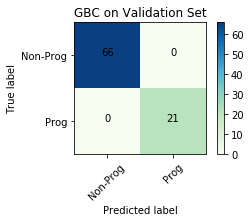

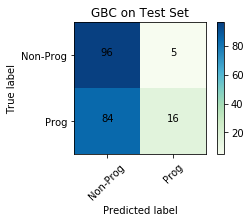

In [17]:
plot_confusion_matrix(conMat_GBC, 
                      normalize    = False,
                      target_names = ['Non-Prog', 'Prog'],
                      title        = "GBC on Validation Set")
plot_confusion_matrix(conMat_GBC_test, 
                      normalize    = False,
                      target_names = ['Non-Prog', 'Prog'],
                      title        = "GBC on Test Set")

## This is the SVC that was not reported in the final report as the accuracy was well below 50%, somewhere around 45 to 48%.

In [ ]:
decision_threshold = 0.5
model = SVC(kernel='rbf', degree=3,random_state=0,probability=True)
model.fit(train_features,train_labels)

val_preds = get_predictions(model, val_features, decision_threshold)
train_preds = get_predictions(model,train_features, decision_threshold)

print("train accuracy: ", np.sum((train_preds==train_labels))/len(train_preds))

tn, fp, fn, tp = confusion_matrix(val_labels,val_preds).ravel()

print(" Val accuracy :", ((tp+tn) / (tp+tn+fp+fn) ))
print(confusion_matrix(val_labels,val_preds))

test_preds = get_predictions(model,test_features,decision_threshold=0.4)
print("test accuracy: ", np.sum((test_preds==test_labels))/len(test_preds))